In [1]:
%load_ext autoreload
%autoreload 2

In [77]:
import os, sys
import numpy as np
from sklearn.model_selection import train_test_split
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from rl_envs_forge.envs.grid_world.grid_world import GridWorld
from rl_envs_forge.envs.grid_world.grid_world import Action

from src.replay_buffer import ReplayBuffer
from src.value_iteration import value_iteration_q_stochastic
from src.policy_iteration import find_optimal_policy_q_stochastic, policy_evaluation_v_stochastic
from src.visualize import draw_simple_gridworld
from src.utils import extract_V_from_Q

In [76]:
# Generate states splits

rows, cols = 10, 10  
terminal_states = {(4, 4): 1.0}

# Generate all possible states and exclude terminal states
all_states = [(row, col) for row in range(rows) for col in range(cols)]
available_states = [state for state in all_states if state not in terminal_states]

def train_validation_split(states, train_ratio=0.8):
    random.shuffle(states)
    split_idx = int(len(states) * train_ratio)
    train_states = states[:split_idx]
    test_states = states[split_idx:]
    return train_states, test_states

# Split the available states into training and validation sets
train_states, test_states = train_validation_split(available_states, train_ratio=0.95)

print("Number of Training States:", len(train_states))
print("Number of Validation States:", len(test_states))

Number of Training States: 94
Number of Validation States: 5


In [4]:
def make_env(rows, cols, start_state, p_success, terminal_states, seed):
    return GridWorld(
        rows=rows,
        cols=cols,
        start_state = start_state,
        walls=None,
        p_success=p_success,
        terminal_states=terminal_states,
        seed = seed,
        rewards = {
            "valid_move": 0,
            "wall_collision": 0,
            "out_of_bounds": 0, 
            "default": 0.0,
        }
    )

def generate_samples(rows, cols, start_state, terminal_states, p_success, num_steps, seed=0):
    dataset = []
    env = make_env(rows, cols, start_state, p_success, terminal_states, seed)
    state = env.reset()
    done = False
    for _ in range(num_steps):
        action = np.random.choice([0, 1, 2, 3])  # UP, RIGHT, DOWN, LEFT
        next_state, reward, done, _, _ = env.step(action)
        
        sample = [state, action, next_state, reward, done]
        dataset.append(sample)
        
        if done:
            state = env.reset()
            done = False
            
        state = next_state
        
    return dataset
    
seed = 0
random_move_frequency = 1.0
num_steps = 10_000

train_dataset = []
for start_state in train_states:
    start_state_dataset = generate_samples(rows, cols, start_state, terminal_states, random_move_frequency, num_steps, seed)
    train_dataset.extend(start_state_dataset)

test_dataset = []
for start_state in test_states:
    start_state_dataset = generate_samples(rows, cols, start_state, terminal_states, random_move_frequency, num_steps, seed)
    test_dataset.extend(start_state_dataset)

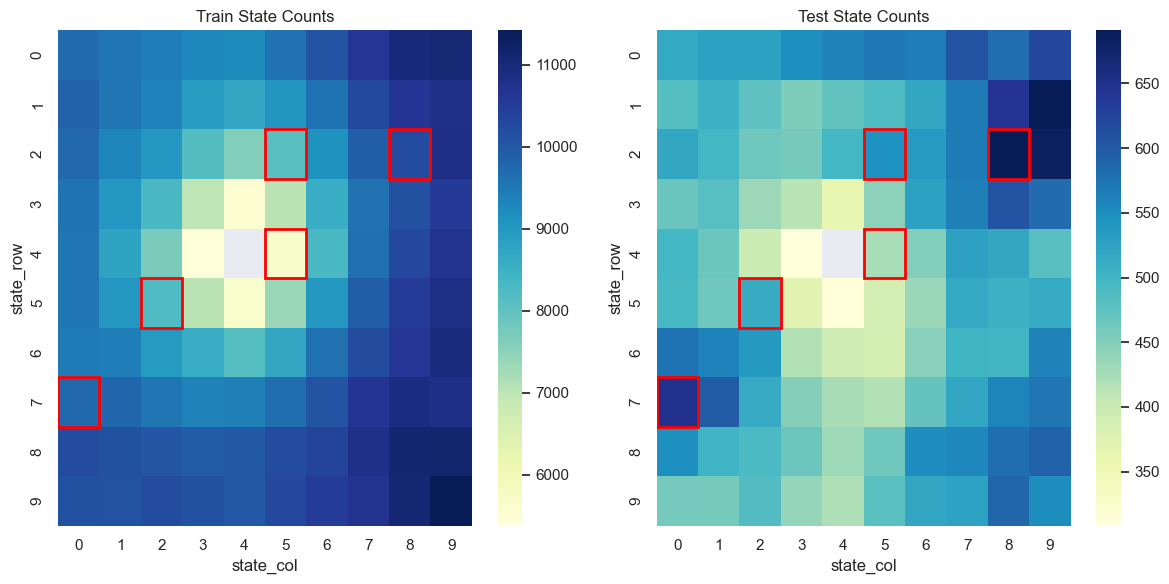

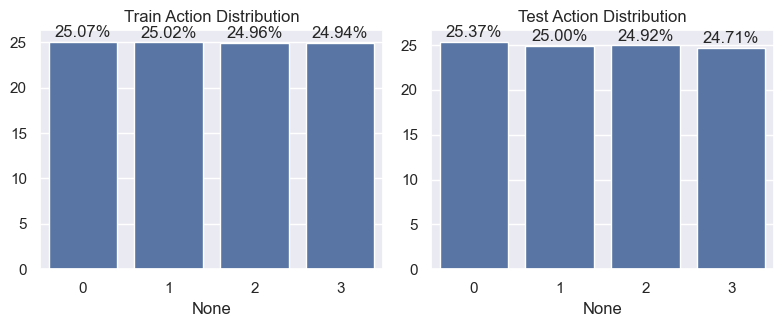

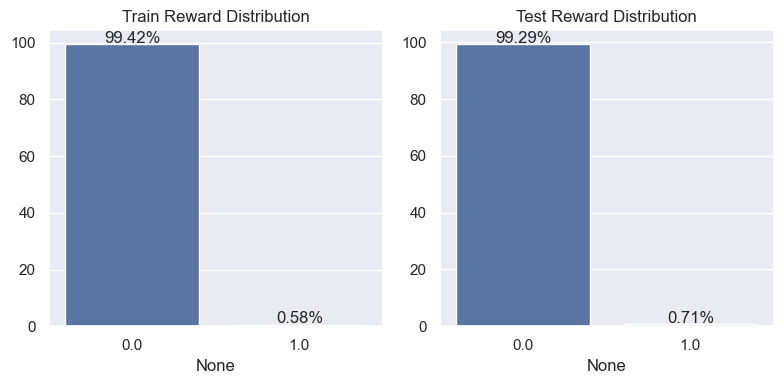

Training Percentage of 'done': 0.58%
Test Percentage of 'done': 0.71%


In [5]:
# Convert dataset to DataFrame
columns = ['state', 'action', 'next_state', 'reward', 'done']

df = pd.DataFrame(train_dataset, columns=columns)
df[['state_row', 'state_col']] = pd.DataFrame(df['state'].tolist(), index=df.index)
df[['next_state_row', 'next_state_col']] = pd.DataFrame(df['next_state'].tolist(), index=df.index)

test_df = pd.DataFrame(test_dataset, columns=columns)
test_df[['state_row', 'state_col']] = pd.DataFrame(test_df['state'].tolist(), index=test_df.index)
test_df[['next_state_row', 'next_state_col']] = pd.DataFrame(test_df['next_state'].tolist(), index=test_df.index)

###### Figure for state counts heatmaps
train_state_counts = df.groupby(['state_row', 'state_col']).size().reset_index(name='counts')
train_state_heatmap = train_state_counts.pivot(index='state_row', columns='state_col', values='counts')

# Test Dataset State Counts
test_state_counts = test_df.groupby(['state_row', 'state_col']).size().reset_index(name='counts')
test_state_heatmap = test_state_counts.pivot(index='state_row', columns='state_col', values='counts')

plt.figure(figsize=(12, 6))

# Plot Train State Counts Heatmap
plt.subplot(1, 2, 1)
sns.heatmap(train_state_heatmap, annot=False, cmap="YlGnBu")
plt.title('Train State Counts')

for state in test_states:
    # Convert state tuple to row, col indices considering the heatmap's orientation
    row, col = state
    plt.gca().add_patch(plt.Rectangle((col, row), 1, 1, fill=False, edgecolor='red', lw=2))


plt.subplot(1, 2, 2)
sns.heatmap(test_state_heatmap, annot=False, cmap="YlGnBu")
plt.title('Test State Counts')

for state in test_states:
    # Convert state tuple to row, col indices considering the heatmap's orientation
    row, col = state
    plt.gca().add_patch(plt.Rectangle((col, row), 1, 1, fill=False, edgecolor='red', lw=2))

plt.tight_layout()
plt.show()

##########
# Training Action Distribution
plt.figure(figsize=(8, 6))
plt.subplot(2, 2, 1)

train_action_counts = df['action'].value_counts(normalize=True) * 100
sns.barplot(x=train_action_counts.index, y=train_action_counts.values)
plt.title('Train Action Distribution')
for i, value in enumerate(train_action_counts.values):
    plt.text(i, value + 0.5, f'{value:.2f}%', ha='center')

# Test Action Distribution
plt.subplot(2, 2, 2)
test_action_counts = test_df['action'].value_counts(normalize=True) * 100
sns.barplot(x=test_action_counts.index, y=test_action_counts.values)
plt.title('Test Action Distribution')
for i, value in enumerate(test_action_counts.values):
    plt.text(i, value + 0.5, f'{value:.2f}%', ha='center')

plt.tight_layout()
plt.show()

##### Figure for actions and rewards
plt.figure(figsize=(8, 4))

# Training Reward Distribution
plt.subplot(1, 2, 1)
train_reward_counts = df['reward'].value_counts(normalize=True, sort=False).sort_index() * 100
sns.barplot(x=train_reward_counts.index, y=train_reward_counts.values)
plt.title('Train Reward Distribution')
for i, value in enumerate(train_reward_counts.values):
    plt.text(i, value + 0.5, f'{value:.2f}%', ha='center')

# Test Reward Distribution
plt.subplot(1, 2, 2)
test_reward_counts = test_df['reward'].value_counts(normalize=True, sort=False).sort_index() * 100
sns.barplot(x=test_reward_counts.index, y=test_reward_counts.values)
plt.title('Test Reward Distribution')
for i, value in enumerate(test_reward_counts.values):
    plt.text(i, value + 0.5, f'{value:.2f}%', ha='center')

plt.tight_layout()
plt.show()

##### Percentages of done
train_done_percentage = df['done'].mean() * 100
test_done_percentage = test_df['done'].mean() * 100
print(f"Training Percentage of 'done': {train_done_percentage:.2f}%")
print(f"Test Percentage of 'done': {test_done_percentage:.2f}%")

In [6]:
# 5 seeds
# Idea 1: generate all the unique transitions in the MDP, use some for training, some for validation 20% 
# OR, variation 2: select initially some transitions we want in validation, and MOVE them from the training to the validation one
# select probability generated by us with softmax(logits, tau 0.1 or 100) logits: random uniform\
# at each experiment modify tau, decrease it
# Compute the times we select each transition by making numpy choice with probabilities
# take  4000 samples like this: in validation we should have all the possible transitions
# TD learning on training data -> Q, minibatch, for each transition, Stop TD learning when we reach Q* within epsilon
# Calculate Q* and Q train, Q test, and compute regret between them, setup terminal state in corner
# TD learning on validation data -> Q


In [ ]:
def softmax(logits, tau):
    # Apply the softmax function with temperature tau
    exp_logits = np.exp(logits / tau)
    return exp_logits / np.sum(exp_logits)

def generate_transitions_observations(transitions_list, num_steps, tau):
    dset_size = len(transitions_list)

    # Generate random logits from a uniform distribution between -1 and 1
    logits = np.random.uniform(0, 1, size=dset_size)

    prob_dist = softmax(logits, tau)

    sampled_indices = np.random.choice(len(transitions_list), size=num_steps, p=prob_dist)
    sampled_transitions = [transitions_list[i] for i in sampled_indices]
    return sampled_transitions

def td_learning(states, actions, training_data, alpha, gamma, epsilon):
    # Initialize Q as a nested dictionary for all state-action pairs
    Q = {state: {action: 0 for action in actions} for state in states}

    # TD Learning process
    converged = False
    iterations = 0
    max_iterations = 10000  # Prevent infinite loops

    while not converged and iterations < max_iterations:
        max_delta = 0
        for (current_state, action, next_state, reward, done, _) in training_data:
            current_state_dict = tuple(current_state)  # Ensure the state is hashable and matches the dict keys
            
            # Skip the update if the current state is terminal or not in the Q dictionary
            if current_state_dict not in Q:
                continue

            if done:
                # No further action is taken if the next state is terminal; assume Q-value is zero for terminal states
                td_target = reward
            else:
                next_state_dict = tuple(next_state)
                # Ensure next_state is in Q; if not, treat it as terminal with zero future rewards
                if next_state_dict in Q:
                    td_target = reward + gamma * max(Q[next_state_dict].values())
                else:
                    td_target = reward

            # TD Update for non-terminal states
            old_q = Q[current_state_dict][action]
            Q[current_state_dict][action] += alpha * (td_target - old_q)
            
            # Track the maximum change in Q-values for convergence check
            delta = abs(old_q - Q[current_state_dict][action])
            max_delta = max(max_delta, delta)

        if max_delta < epsilon:
            converged = True
        
        iterations += 1

        return Q
    
def compute_regret(Q_star, Q_td, states, actions):
    total_regret = 0
    regrets = {state: {action: 0 for action in actions} for state in states}

    for state in states:
        for action in actions:
            # Calculate regret for the current state-action pair
            regret = Q_star[state].get(action, 0) - Q_td[state].get(action, 0)
            regrets[state][action] = regret
            
            # Update the total regret
            total_regret += abs(regret)  # Using absolute value of regret

    return total_regret, regrets


In [92]:
# Env settings 
start_state = (0, 0)
terminal_states = {(9, 9): 1.0}
rows, cols = 10, 10
p_success = 1
seed = 0

num_steps = 40_000

# Learning hyperparameters
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 1e-6  # Convergence criterion


def run_sampling_regret_experiment(tau, seed):
    np.random.seed(seed)
    env = make_env(rows, cols, start_state, p_success, terminal_states, seed)
    
    optimal_policy, Q_star = find_optimal_policy_q_stochastic(env.mdp, gamma, epsilon)

    transitions_list = [(key[0], key[1], *value[0]) for key, value in env.mdp.items()]
    transitions_train, transitions_val = train_test_split(transitions_list, test_size=0.2, random_state=seed)
    sampled_transitions_train = generate_transitions_observations(transitions_train, num_steps, tau=tau)
    sampled_transitions_val = generate_transitions_observations(transitions_val, num_steps//4, tau=tau)

    states = list(set([s for s, _ in env.mdp.keys()]))
    actions = list(set([a for _, a in env.mdp.keys()]))

    Q_train = td_learning(states, actions, sampled_transitions_train, alpha, gamma, epsilon)
    total_regret_train, regrets = compute_regret(Q_star, Q_train, states, actions)

    Q_val = td_learning(states, actions, sampled_transitions_val, alpha, gamma, epsilon)
    total_regret_val, _ = compute_regret(Q_star, Q_val, states, actions)

    return total_regret_train, total_regret_val

records = []
for tau in [0.01, 0.1, 0.5, 1.0, 10, 20, 50, 100]:
    for seed in range(5):
        total_regret_train, total_regret_val = run_sampling_regret_experiment(tau, seed)
        records.append({'tau': tau, 'seed': seed, 'total_regret_train': total_regret_train, 'total_regret_val': total_regret_val})

results_df = pd.DataFrame(records)
# results_df

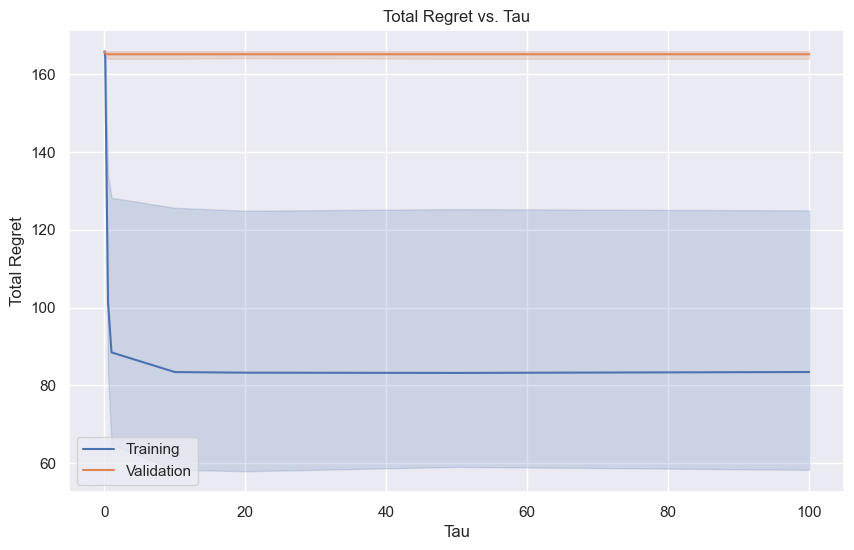

In [93]:
# Plot the results df
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='tau', y='total_regret_train', label='Training')
sns.lineplot(data=results_df, x='tau', y='total_regret_val', label='Validation')
plt.xlabel('Tau')
plt.ylabel('Total Regret')
plt.title('Total Regret vs. Tau')
plt.legend()
plt.show()

### Validating resulting Vs

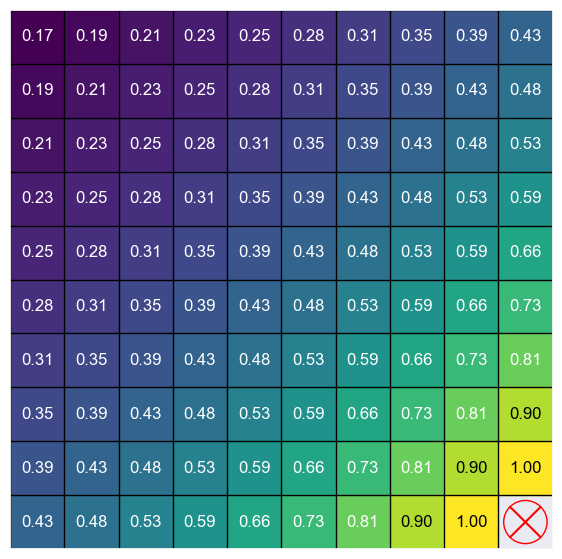

Total Regret Train: 42.252460087768476


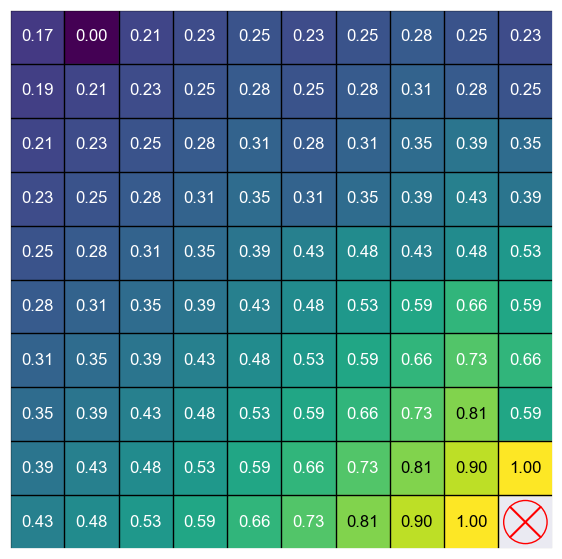

Total Regret Val: 165.88790975622808


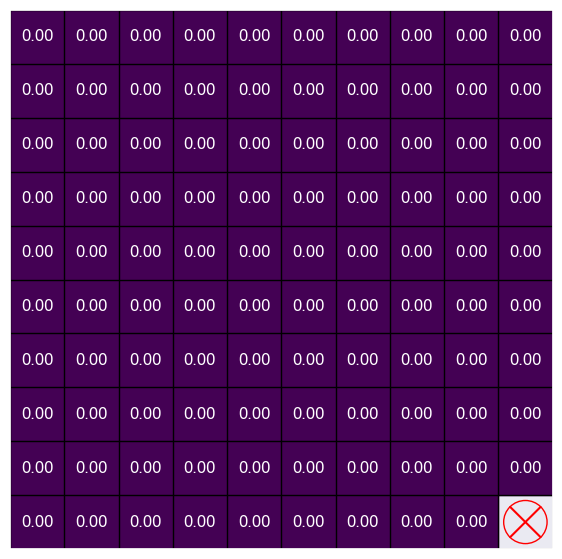

In [88]:
# Env settings 
start_state = (0, 0)
terminal_states = {(9, 9): 1.0}
rows, cols = 10, 10
p_success = 1
seed = 0

num_steps = 400_000 # very sensitive with sample size / learning rate
tau = 100

# Learning hyperparameters
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.01  # Convergence criterion


np.random.seed(seed)
env = make_env(rows, cols, start_state, p_success, terminal_states, seed)

optimal_policy, Q_star = find_optimal_policy_q_stochastic(env.mdp, gamma, epsilon)

transitions_list = [(key[0], key[1], *value[0]) for key, value in env.mdp.items()]
transitions_train, transitions_val = train_test_split(transitions_list, test_size=0.2, random_state=seed)
sampled_transitions_train = generate_transitions_observations(transitions_train, num_steps, tau=tau)
sampled_transitions_val = generate_transitions_observations(transitions_val, num_steps//4, tau=tau)

states = list(set([s for s, _ in env.mdp.keys()]))
actions = list(set([a for _, a in env.mdp.keys()]))

Q_train = td_learning(states, actions, sampled_transitions_train, alpha, gamma, epsilon)
total_regret_train, regrets = compute_regret(Q_star, Q_train, states, actions)

Q_val = td_learning(states, actions, sampled_transitions_val, alpha, gamma, epsilon)
total_regret_val, _ = compute_regret(Q_star, Q_val, states, actions)

t_r_dict = env.mdp

# Extract V from Q
V_star = extract_V_from_Q(Q_star, states)
V_train = extract_V_from_Q(Q_train, states)
V_val = extract_V_from_Q(Q_val, states)

# Grid shape and walls for visualization
grid_shape = (env.rows, env.cols)
walls = env.walls  # Assuming walls are defined as a set of tuples (row, col)

# Draw the GridWorld with the optimal policy and value function
draw_simple_gridworld(
    grid_shape,
    walls,
    V_star,
    env.terminal_states,
    policy=None,
    enable_heatmap=True,
)

print(f"Total Regret Train: {total_regret_train}")
draw_simple_gridworld(
    grid_shape,
    walls,
    V_train,
    env.terminal_states,
    policy=None,
    enable_heatmap=True,
)

print(f"Total Regret Val: {total_regret_val}")
draw_simple_gridworld(
    grid_shape,
    walls,
    V_val,
    env.terminal_states,
    policy=None,
    enable_heatmap=True,
)

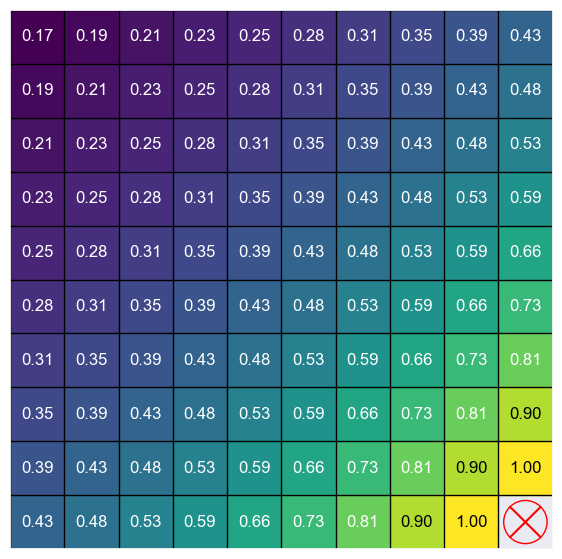

Total Regret Train: 9.802159084415507e-13


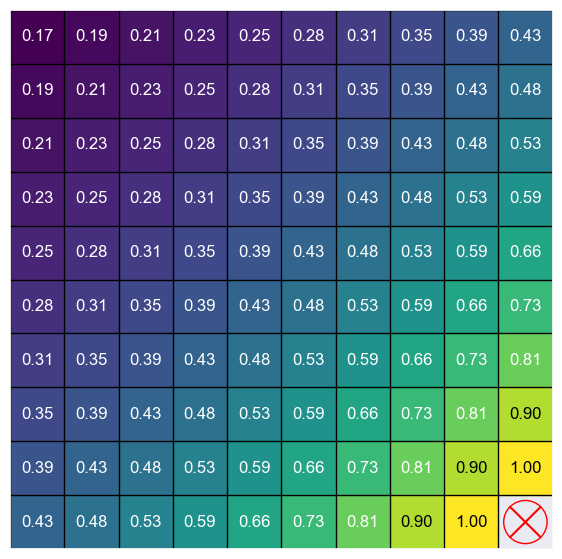

Total Regret Val: 0.06455099212238558


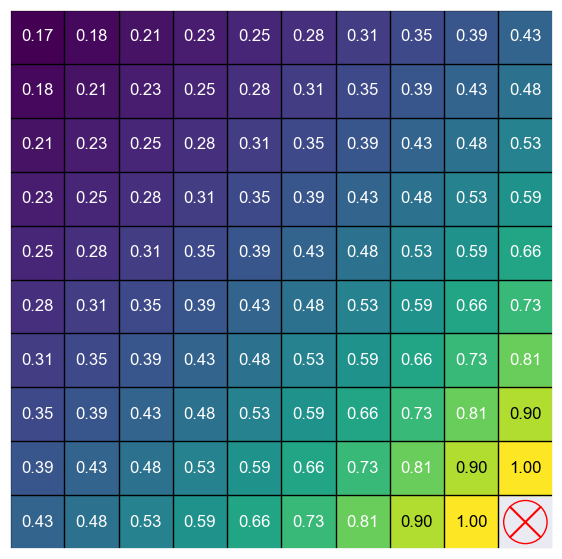

In [87]:
# Env settings 
start_state = (0, 0)
terminal_states = {(9, 9): 1.0}
rows, cols = 10, 10
p_success = 1
seed = 0

tau = 100
num_steps = 400_000

# Learning hyperparameters
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.01  # Convergence criterion


np.random.seed(seed)
env = make_env(rows, cols, start_state, p_success, terminal_states, seed)

optimal_policy, Q_star = find_optimal_policy_q_stochastic(env.mdp, gamma, epsilon)

transitions_list = [(key[0], key[1], *value[0]) for key, value in env.mdp.items()]
transitions_train, transitions_val = train_test_split(transitions_list, test_size=0.2, random_state=seed)
sampled_transitions_train = generate_transitions_observations(transitions_list, num_steps, tau=tau)
sampled_transitions_val = generate_transitions_observations(transitions_list, num_steps//4, tau=tau)

states = list(set([s for s, _ in env.mdp.keys()]))
actions = list(set([a for _, a in env.mdp.keys()]))

Q_train = td_learning(states, actions, sampled_transitions_train, alpha, gamma, epsilon)
total_regret_train, regrets = compute_regret(Q_star, Q_train, states, actions)

Q_val = td_learning(states, actions, sampled_transitions_val, alpha, gamma, epsilon)
total_regret_val, _ = compute_regret(Q_star, Q_val, states, actions)

t_r_dict = env.mdp

# Extract V from Q
V_star = extract_V_from_Q(Q_star, states)
V_train = extract_V_from_Q(Q_train, states)
V_val = extract_V_from_Q(Q_val, states)

# Grid shape and walls for visualization
grid_shape = (env.rows, env.cols)
walls = env.walls  # Assuming walls are defined as a set of tuples (row, col)

# Draw the GridWorld with the optimal policy and value function
draw_simple_gridworld(
    grid_shape,
    walls,
    V_star,
    env.terminal_states,
    policy=None,
    enable_heatmap=True,
)

print(f"Total Regret Train: {total_regret_train}")
draw_simple_gridworld(
    grid_shape,
    walls,
    V_train,
    env.terminal_states,
    policy=None,
    enable_heatmap=True,
)

print(f"Total Regret Val: {total_regret_val}")
draw_simple_gridworld(
    grid_shape,
    walls,
    V_val,
    env.terminal_states,
    policy=None,
    enable_heatmap=True,
)

Text(0.5, 1.0, 'Train State Counts')

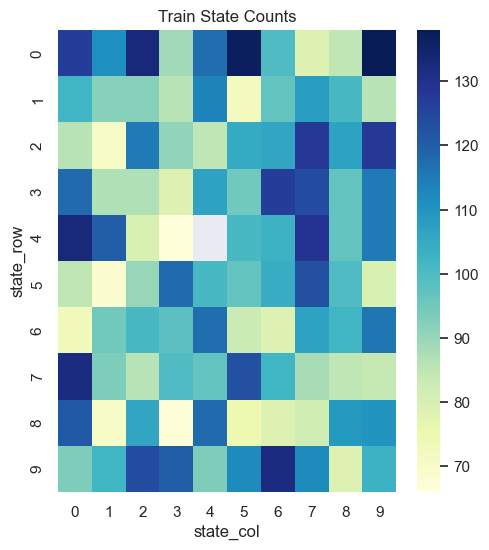

In [62]:
# # Convert dataset to DataFrame
# columns = ['state', 'action', 'next_state', 'reward', 'done', 'prob']

# df = pd.DataFrame(sampled_transitions, columns=columns)
# df[['state_row', 'state_col']] = pd.DataFrame(df['state'].tolist(), index=df.index)
# df[['next_state_row', 'next_state_col']] = pd.DataFrame(df['next_state'].tolist(), index=df.index)

# # test_df = pd.DataFrame(test_dataset, columns=columns)
# # test_df[['state_row', 'state_col']] = pd.DataFrame(test_df['state'].tolist(), index=test_df.index)
# # test_df[['next_state_row', 'next_state_col']] = pd.DataFrame(test_df['next_state'].tolist(), index=test_df.index)

# ###### Figure for state counts heatmaps
# train_state_counts = df.groupby(['state_row', 'state_col']).size().reset_index(name='counts')
# train_state_heatmap = train_state_counts.pivot(index='state_row', columns='state_col', values='counts')

# # Test Dataset State Counts
# test_state_counts = test_df.groupby(['state_row', 'state_col']).size().reset_index(name='counts')
# test_state_heatmap = test_state_counts.pivot(index='state_row', columns='state_col', values='counts')

# plt.figure(figsize=(12, 6))

# # Plot Train State Counts Heatmap
# plt.subplot(1, 2, 1)
# sns.heatmap(train_state_heatmap, annot=False, cmap="YlGnBu")
# plt.title('Train State Counts')